In [1]:
import pandas as pd
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
import torch.utils.data
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from random import randint

Using TensorFlow backend.


In [2]:
! curl --silent -L -o data.zip "https://drive.google.com/uc?export=download&id=1d6eUqRstk7NIpyASzbuIsDvBdHEwfU0g"
! unzip -q data.zip
! ls data

replace data/machine_vocab.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
data.csv  human_vocab.json  machine_vocab.json


In [3]:
def load_data(path):
    df = pd.read_csv(path, header=None)
    X = df[0].values
    y = df[1].values
    x_tok = Tokenizer(char_level=True, filters='')
    x_tok.fit_on_texts(X)
    y_tok = Tokenizer(char_level=True, filters='')
    y_tok.fit_on_texts(y)
    
    X = x_tok.texts_to_sequences(X)
    y = y_tok.texts_to_sequences(y)
    
    X = pad_sequences(X)
    y = np.asarray(y)
    
    return X, y, x_tok.word_index, y_tok.word_index

X, y, x_wid, y_wid= load_data('data/data.csv')
x_id2w = dict(zip(x_wid.values(), x_wid.keys()))
y_id2w = dict(zip(y_wid.values(), y_wid.keys()))
X_train, X_test, y_train, y_test = train_test_split(X, y)
print('train size: {} - test size: {}'.format(len(X_train), len(X_test)))

train size: 18750 - test size: 6250


In [4]:
hidden_size = 128
learning_rate = 0.001
decoder_learning_ratio = 0.1

# plus 1 is padding token
input_size = len(x_wid) + 1
# plus 2 is sos and eos token
output_size = len(y_wid) + 2
sos_idx = len(y_wid) 
eos_idx = len(y_wid) + 1

max_length = y.shape[1]
print("input vocab: {} - output vocab: {} - length of target: {}".format(input_size, output_size, max_length))

input vocab: 35 - output vocab: 13 - length of target: 10


In [0]:
def decoder_sentence(idxs, vocab):
    text = ''.join([vocab[w] for w in idxs if (w > 0) and (w in vocab)])
    return text

In [0]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
    
    def forward(self, input):
        # input: SxB        
        embedded = self.embedding(input)
        output, hidden = self.gru(embedded)
        return output, hidden # SxBxH, 1xBxH              

class Attn(nn.Module):
    def __init__(self, hidden_size):
        super(Attn ,self).__init__()
        
    def forward(self, hidden, encoder_outputs):
        # encoder_outputs: TxBxH
        # hidden: SxBxH
        encoder_outputs = torch.transpose(encoder_outputs, 0, 1) #BxTxH
        hidden = torch.transpose(torch.transpose(hidden, 0, 1), 1, 2) # BxHxS
        energies = torch.bmm(encoder_outputs, hidden) # BxTxS
        energies = torch.transpose(energies, 1, 2) # BxSxT
        attn_weights = F.softmax(energies, dim=-1) #BxSxT
        
        output = torch.bmm(attn_weights, encoder_outputs) # BxSxH
        output = torch.transpose(output, 0, 1) # SxBxH
        attn_weights = torch.transpose(attn_weights, 0, 1) #SxBxT
        
        return output, attn_weights
    
class Decoder(nn.Module):
    def __init__(self, output_size, hidden_size, dropout):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attn = Attn(hidden_size)
        self.dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.concat = nn.Linear(self.hidden_size*2, hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)
        
    def forward(self, input, hidden, encoder_outputs):
        # input: SxB
        # encoder_outputs: BxSxH
        # hidden: 1xBxH
        embedded = self.embedding(input) # 1xBxH
        embedded = self.dropout(embedded)
        rnn_output, hidden = self.gru(embedded, hidden)  #SxBxH, 1xBxH
        context, attn_weights = self.attn(rnn_output, encoder_outputs) # SxBxH
        concat_input = torch.cat((rnn_output, context), -1)
        concat_output = torch.tanh(self.concat(concat_input)) #SxBxH
        
        output = self.out(concat_output) # SxBxoutput_size
        return output, hidden, attn_weights

  

In [0]:
encoder = Encoder(input_size, hidden_size)
decoder = Decoder(output_size, hidden_size, 0.1)

# Initialize optimizers and criterion
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)
criterion = nn.CrossEntropyLoss()


input_encoder = torch.randint(1, input_size, (34, 6), dtype=torch.long)
encoder_outputs, hidden = encoder(input_encoder)
input_decoder = torch.randint(1, output_size, (10, 6), dtype=torch.long)
output, hidden, attn_weights = decoder(input_decoder, hidden, encoder_outputs)

In [0]:
def forward_and_compute_loss(inputs, targets, encoder, decoder, criterion):
    batch_size = inputs.size()[1]
    
    sos = Variable(torch.ones((1, batch_size), dtype=torch.long)*sos_idx)
    eos = Variable(torch.ones((1, batch_size), dtype=torch.long)*eos_idx)
    
    decoder_inputs = torch.cat((sos, targets), dim=0)
    decoder_targets = torch.cat((targets, eos), dim=0)
    
    encoder_outputs, encoder_hidden = encoder(inputs)
    output, hidden, attn_weights = decoder(decoder_inputs, encoder_hidden, encoder_outputs)
    
    output = torch.transpose(torch.transpose(output, 0, 1), 1, 2) # BxCxS
    decoder_targets = torch.transpose(decoder_targets, 0, 1)
    loss = criterion(output, decoder_targets)
    
    return loss, output

def train(inputs, targets,  encoder, decoder, encoder_optimizer, decoder_optimizer, criterion):
    
    encoder.train()
    decoder.train()
    
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    train_loss, output = forward_and_compute_loss(inputs, targets,encoder, decoder,criterion)    
    
    train_loss.backward()
    
    encoder_optimizer.step()
    decoder_optimizer.step()
            
    return train_loss.item()

def evaluate(inputs, targets, encoder, decoder, criterion):
    encoder.eval()
    decoder.eval()
    eval_loss, output = forward_and_compute_loss(inputs, targets, encoder, decoder,criterion)
    output = torch.transpose(output, 1, 2)
    pred_idx = torch.argmax(output, dim=-1).squeeze(-1)
    pred_idx = pred_idx.data.cpu().numpy()
    
    return eval_loss.item(), pred_idx

def predict(inputs, encoder, decoder, target_length=max_length):    
    batch_size = inputs.size()[1]
    decoder_inputs = Variable(torch.ones((1, batch_size), dtype=torch.long)*sos_idx)
    encoder_outputs, encoder_hidden = encoder(inputs)
    hidden = encoder_hidden
    preds = []
    attn_weights = []
    for i in range(target_length):
        output, hidden, attn_weight = decoder(decoder_inputs, hidden, encoder_outputs)
        output = output.squeeze(dim=0)
        pred_idx = torch.argmax(output, dim=-1)
        
        decoder_inputs = Variable(torch.ones((1, batch_size), dtype=torch.long)*pred_idx)
        preds.append(decoder_inputs)
        attn_weights.append(attn_weight.detach())

    preds = torch.cat(preds, dim=0)
    preds = torch.transpose(preds, 0, 1)
    attn_weights = torch.cat(attn_weights, dim=0)
    attn_weights = torch.transpose(attn_weights, 0, 1)
    return preds, attn_weights

In [9]:
train(input_encoder, input_decoder, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)

2.58532977104187

In [10]:
epochs = 10
batch_size = 64

encoder = Encoder(input_size, hidden_size)
decoder = Decoder(output_size, hidden_size, 0.1)

# Initialize optimizers and criterion
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)
criterion = nn.CrossEntropyLoss()

X_val = torch.tensor(X_test, dtype=torch.long)
y_val = torch.tensor(y_test, dtype=torch.long)
X_val = torch.transpose(X_val, 0, 1)
y_val = torch.transpose(y_val, 0, 1)

for epoch in range(epochs):
    for idx in range(len(X_train)//batch_size):
        X_train_batch = torch.tensor(X_train[batch_size*idx:batch_size*(idx+1)], dtype=torch.long)
        y_train_batch = torch.tensor(y_train[batch_size*idx:batch_size*(idx+1)], dtype=torch.long)
        
        X_train_batch = torch.transpose(X_train_batch, 0, 1)
        y_train_batch = torch.transpose(y_train_batch, 0, 1)
        train_loss= train(X_train_batch, y_train_batch, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
    eval_loss, preds = evaluate(X_val, y_val, encoder, decoder, criterion)
    
    print('Epoch {} - train loss: {:.3f} - eval loss: {:.3f}'.format(epoch, train_loss, eval_loss))
    print_idx = np.random.randint(0, len(preds), 3)
    for i in print_idx:
        x_val = decoder_sentence(X_val[:,i].numpy(), x_id2w)
        y_pred = decoder_sentence(preds[i], y_id2w)
        print(" {:<35s}\t{:>10}".format(x_val, y_pred))

Epoch 0 - train loss: 0.772 - eval loss: 0.780
 30 tháng 4 1989                    	1989-07-00
 16 thg 12, 1998                    	1998-00-02
 thứ bảy, ngày 19 tháng 8 năm 2017  	2018-07-22
Epoch 1 - train loss: 0.113 - eval loss: 0.098
 1 thg 12, 1991                     	1991-12-11
 tháng 8 25 2017                    	2017-08-25
 ngày 21 tháng 09 năm 1995          	1995-09-21
Epoch 2 - train loss: 0.059 - eval loss: 0.051
 10.02.77                           	1977-02-10
 23 thg 4, 1980                     	1980-04-23
 tháng 3 30 2000                    	2000-03-30
Epoch 3 - train loss: 0.051 - eval loss: 0.042
 thứ hai, ngày 12 tháng 6 năm 1972  	1972-06-12
 17 03 95                           	1995-03-17
 tháng 4 3, 1989                    	1989-04-33
Epoch 4 - train loss: 0.046 - eval loss: 0.038
 13 thg 5, 2008                     	2008-05-13
 05/08/2003                         	2003-08-05
 11 thg 11 2015                     	2015-11-11
Epoch 5 - train loss: 0.040 - eval loss: 0.03

In [0]:
preds, attn_weights = predict(X_val ,encoder, decoder, target_length=10)

In [0]:
def show_attention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticks(np.arange(len(input_sentence)))
    ax.set_xticklabels(list(input_sentence), rotation=90)
    ax.set_yticks(np.arange(len(output_words)))
    ax.set_yticklabels(list(output_words))
    ax.grid()
    ax.set_xlabel('Input Sequence')
    ax.set_ylabel('Output Sequence')
    plt.show()

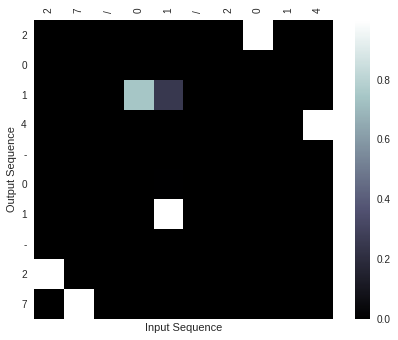

In [20]:
show_idx = randint(0, len(preds))
text_x = decoder_sentence(X_val[:,show_idx].numpy(), x_id2w)
text_y = decoder_sentence(preds[show_idx].numpy(), y_id2w)
attn_weight = attn_weights[show_idx, :, -len(text_x):]
show_attention(text_x, text_y, attn_weight)